In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix


In [2]:
path_to_query_adata = '/mnt/sata3/Dhruv_Analysis_1/2025_05_22_IL-15_KO/combined/final_with_resolvi_layer.h5ad'
query_adata = sc.read(path_to_query_adata)

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
import sys
sys.path.insert(0, '/home/amonell/piloting/scvi-tools/src')
print("Added to path:", sys.path[0])

import scvi.external.resolvi as RESOLVI
import scvi
print("Importing from:", scvi.external.resolvi.__file__)

Added to path: /home/amonell/piloting/scvi-tools/src
Importing from: /home/amonell/piloting/scvi-tools/src/scvi/external/resolvi/__init__.py


In [4]:
sc.pp.subsample(query_adata)

TypeError: Either `fraction` or `n` must be set.

In [5]:
RESOLVI.RESOLVI.setup_anndata(query_adata, labels_key="resolvi_predicted", layer="counts", batch_key="batch", perturbation_key='mapped_batch', control_perturbation='B6, IgG')

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 23 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_scanvi.py:56: UserWarning: Category 23 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [6]:
supervised_resolvi = RESOLVI.RESOLVI(
    query_adata, semisupervised=True
)

priors = supervised_resolvi.compute_dataset_dependent_priors()
print(priors)


{'background_ratio': 0.0006679625, 'median_distance': 13514.6845703125, 'mean_log_counts': 5.209486, 'std_log_counts': 0.90377253}


In [7]:
supervised_resolvi.module.guide.downsample_counts_mean = float(
    supervised_resolvi.module.guide.downsample_counts_mean
)
supervised_resolvi.module.guide.downsample_counts_std = float(
    supervised_resolvi.module.guide.downsample_counts_std
)
supervised_resolvi.train(
    max_epochs=100,
    check_val_every_n_epoch=1,
    lr=3e-4
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_worke

Training:   0%|          | 0/100 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


In [34]:

cell_indices = np.where((query_adata.obs['resolvi_predicted'] == 'Enterocyte_1') & (query_adata.obs['mapped_batch'] == 'IL15KO, IgG'))[0]
effects_cells = supervised_resolvi.get_perturbation_effects(
    indices=cell_indices
)

Number of perturbations: 3
Computing effects for perturbations: [1, 2]


In [35]:
effects_cells[['Aldh1a1', 'Muc2', 'Sell', 'Il18rap', 'Xist', 'Il15']]

,Aldh1a1,Muc2,Sell,Il18rap,Xist,Il15
perturbation_1,0.402060,3.630694,0.372833,0.679334,0.010986,1.074222
perturbation_2,0.191547,0.203113,-0.039884,0.011113,0.000000,-0.129082


In [ ]:
effects_cells[['Upp1', 'Cxcl9', 'Ifng', 'Il7r', 'Il21r', 'Ccr6']]

,Upp1,Cxcl9,Ifng,Il7r,Il21r,Ccr6
perturbation_1,6.923032,0.403849,0.140029,0.613606,0.071563,0.292215
perturbation_2,1.923160,0.411055,0.012937,0.066058,-0.000905,0.056875


/tmp/ipykernel_3046302/1939469881.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('mapped_batch').mean().reset_index()


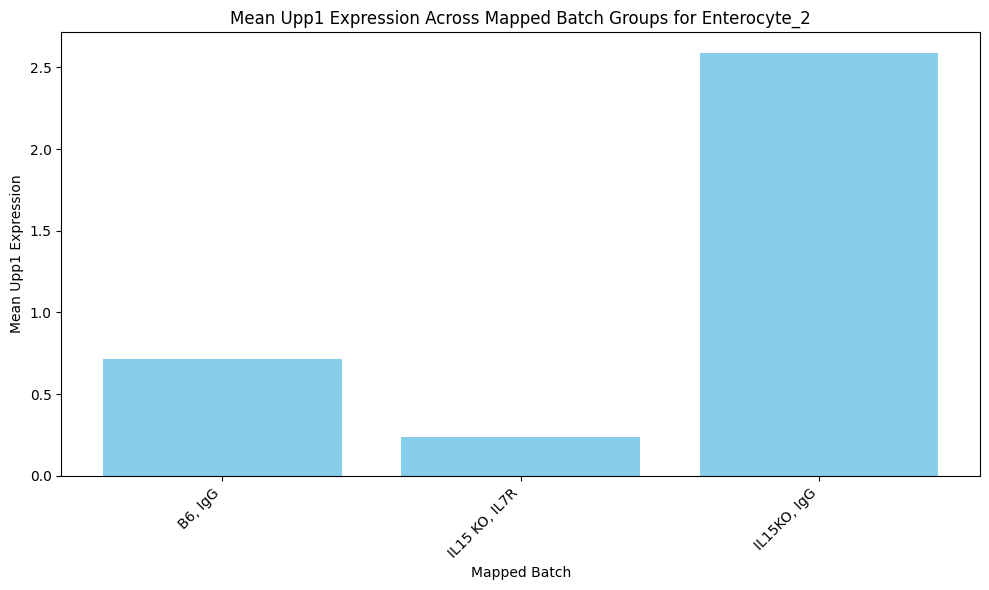

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gene_expression_in_resolvi(gene_name, resolvi_predicted='Enterocyte_1'):
    # Filter the data for the specific 'resolvi_predicted' category
    filtered_indices = query_adata.obs['resolvi_predicted'] == resolvi_predicted
    gene_expression = query_adata.X[filtered_indices, query_adata.var.index == gene_name].flatten()
    mapped_batch_values = query_adata.obs.loc[filtered_indices, 'mapped_batch'].values

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        f'{gene_name}_expression': gene_expression,
        'mapped_batch': mapped_batch_values
    })

    # Group by mapped_batch and calculate mean expression
    grouped_df = df.groupby('mapped_batch').mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(grouped_df['mapped_batch'], grouped_df[f'{gene_name}_expression'], color='skyblue')
    plt.xlabel('Mapped Batch')
    plt.ylabel(f'Mean {gene_name} Expression')
    plt.title(f'Mean {gene_name} Expression Across Mapped Batch Groups for {resolvi_predicted}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
plot_gene_expression_in_resolvi('Upp1', resolvi_predicted='Enterocyte_2')


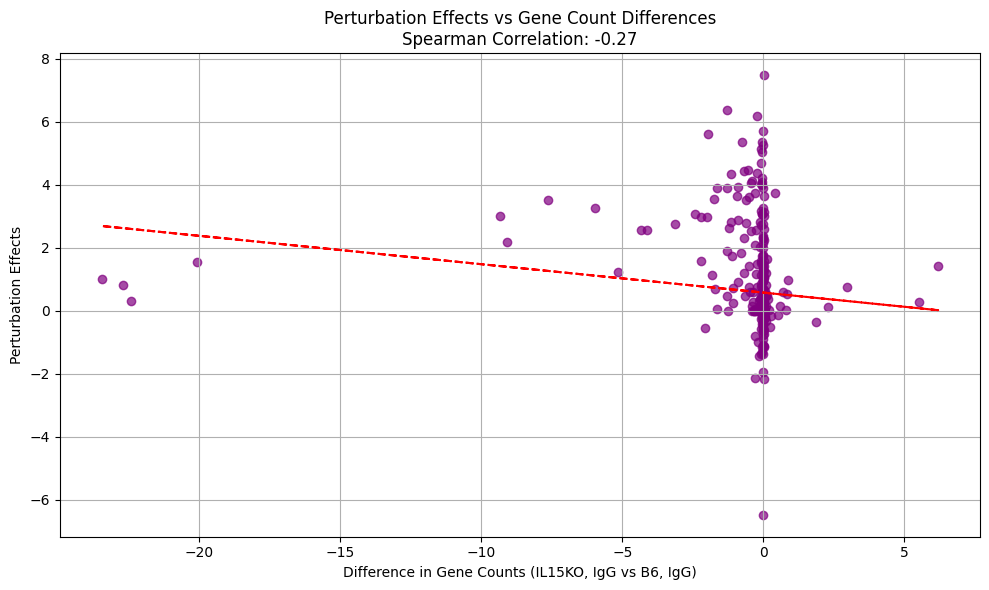

In [24]:

from scipy.stats import spearmanr
import numpy as np

perturbation_effects = effects_cells.loc['perturbation_2'].values
# Calculate the difference in gene counts between the two batches
batch1_counts = query_adata[(query_adata.obs['mapped_batch'] == 'IL15KO, IgG') & (query_adata.obs['resolvi_predicted'] == 'Enterocyte_2')].X.mean(axis=0)
batch2_counts = query_adata[(query_adata.obs['mapped_batch'] == 'B6, IgG') & (query_adata.obs['resolvi_predicted'] == 'Enterocyte_2')].X.mean(axis=0)
gene_count_diff = batch1_counts - batch2_counts

# Filter perturbation effects where values are less than 0.05
valid_indices = np.abs(perturbation_effects) >= 0
gene_count_diff_filtered = gene_count_diff[valid_indices]
perturbation_effects_filtered = perturbation_effects[valid_indices]

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(gene_count_diff_filtered, perturbation_effects_filtered)

# Plot the perturbation effects against the gene count differences
plt.figure(figsize=(10, 6))
plt.scatter(gene_count_diff_filtered, perturbation_effects_filtered, color='purple', alpha=0.7)

# Add line of best fit
m, b = np.polyfit(gene_count_diff_filtered, perturbation_effects_filtered, 1)
plt.plot(gene_count_diff_filtered, m * gene_count_diff_filtered + b, color='red', linestyle='--')

plt.xlabel('Difference in Gene Counts (IL15KO, IgG vs B6, IgG)')
plt.ylabel('Perturbation Effects')
plt.title(f'Perturbation Effects vs Gene Count Differences\nSpearman Correlation: {spearman_corr:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
batch1 = 'IL15KO, IgG_True'
batch2 = 'B6, IgG_True'
de_result_importance = supervised_resolvi.differential_expression(
    query_adata,
    groupby="mapped_batch_P14",
    group1=batch1,
    group2=batch2,
    weights="importance",
    pseudocounts=1e-2,
    delta=0.05,
    filter_outlier_cells=True,
    mode="change",
    test_mode="three",
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

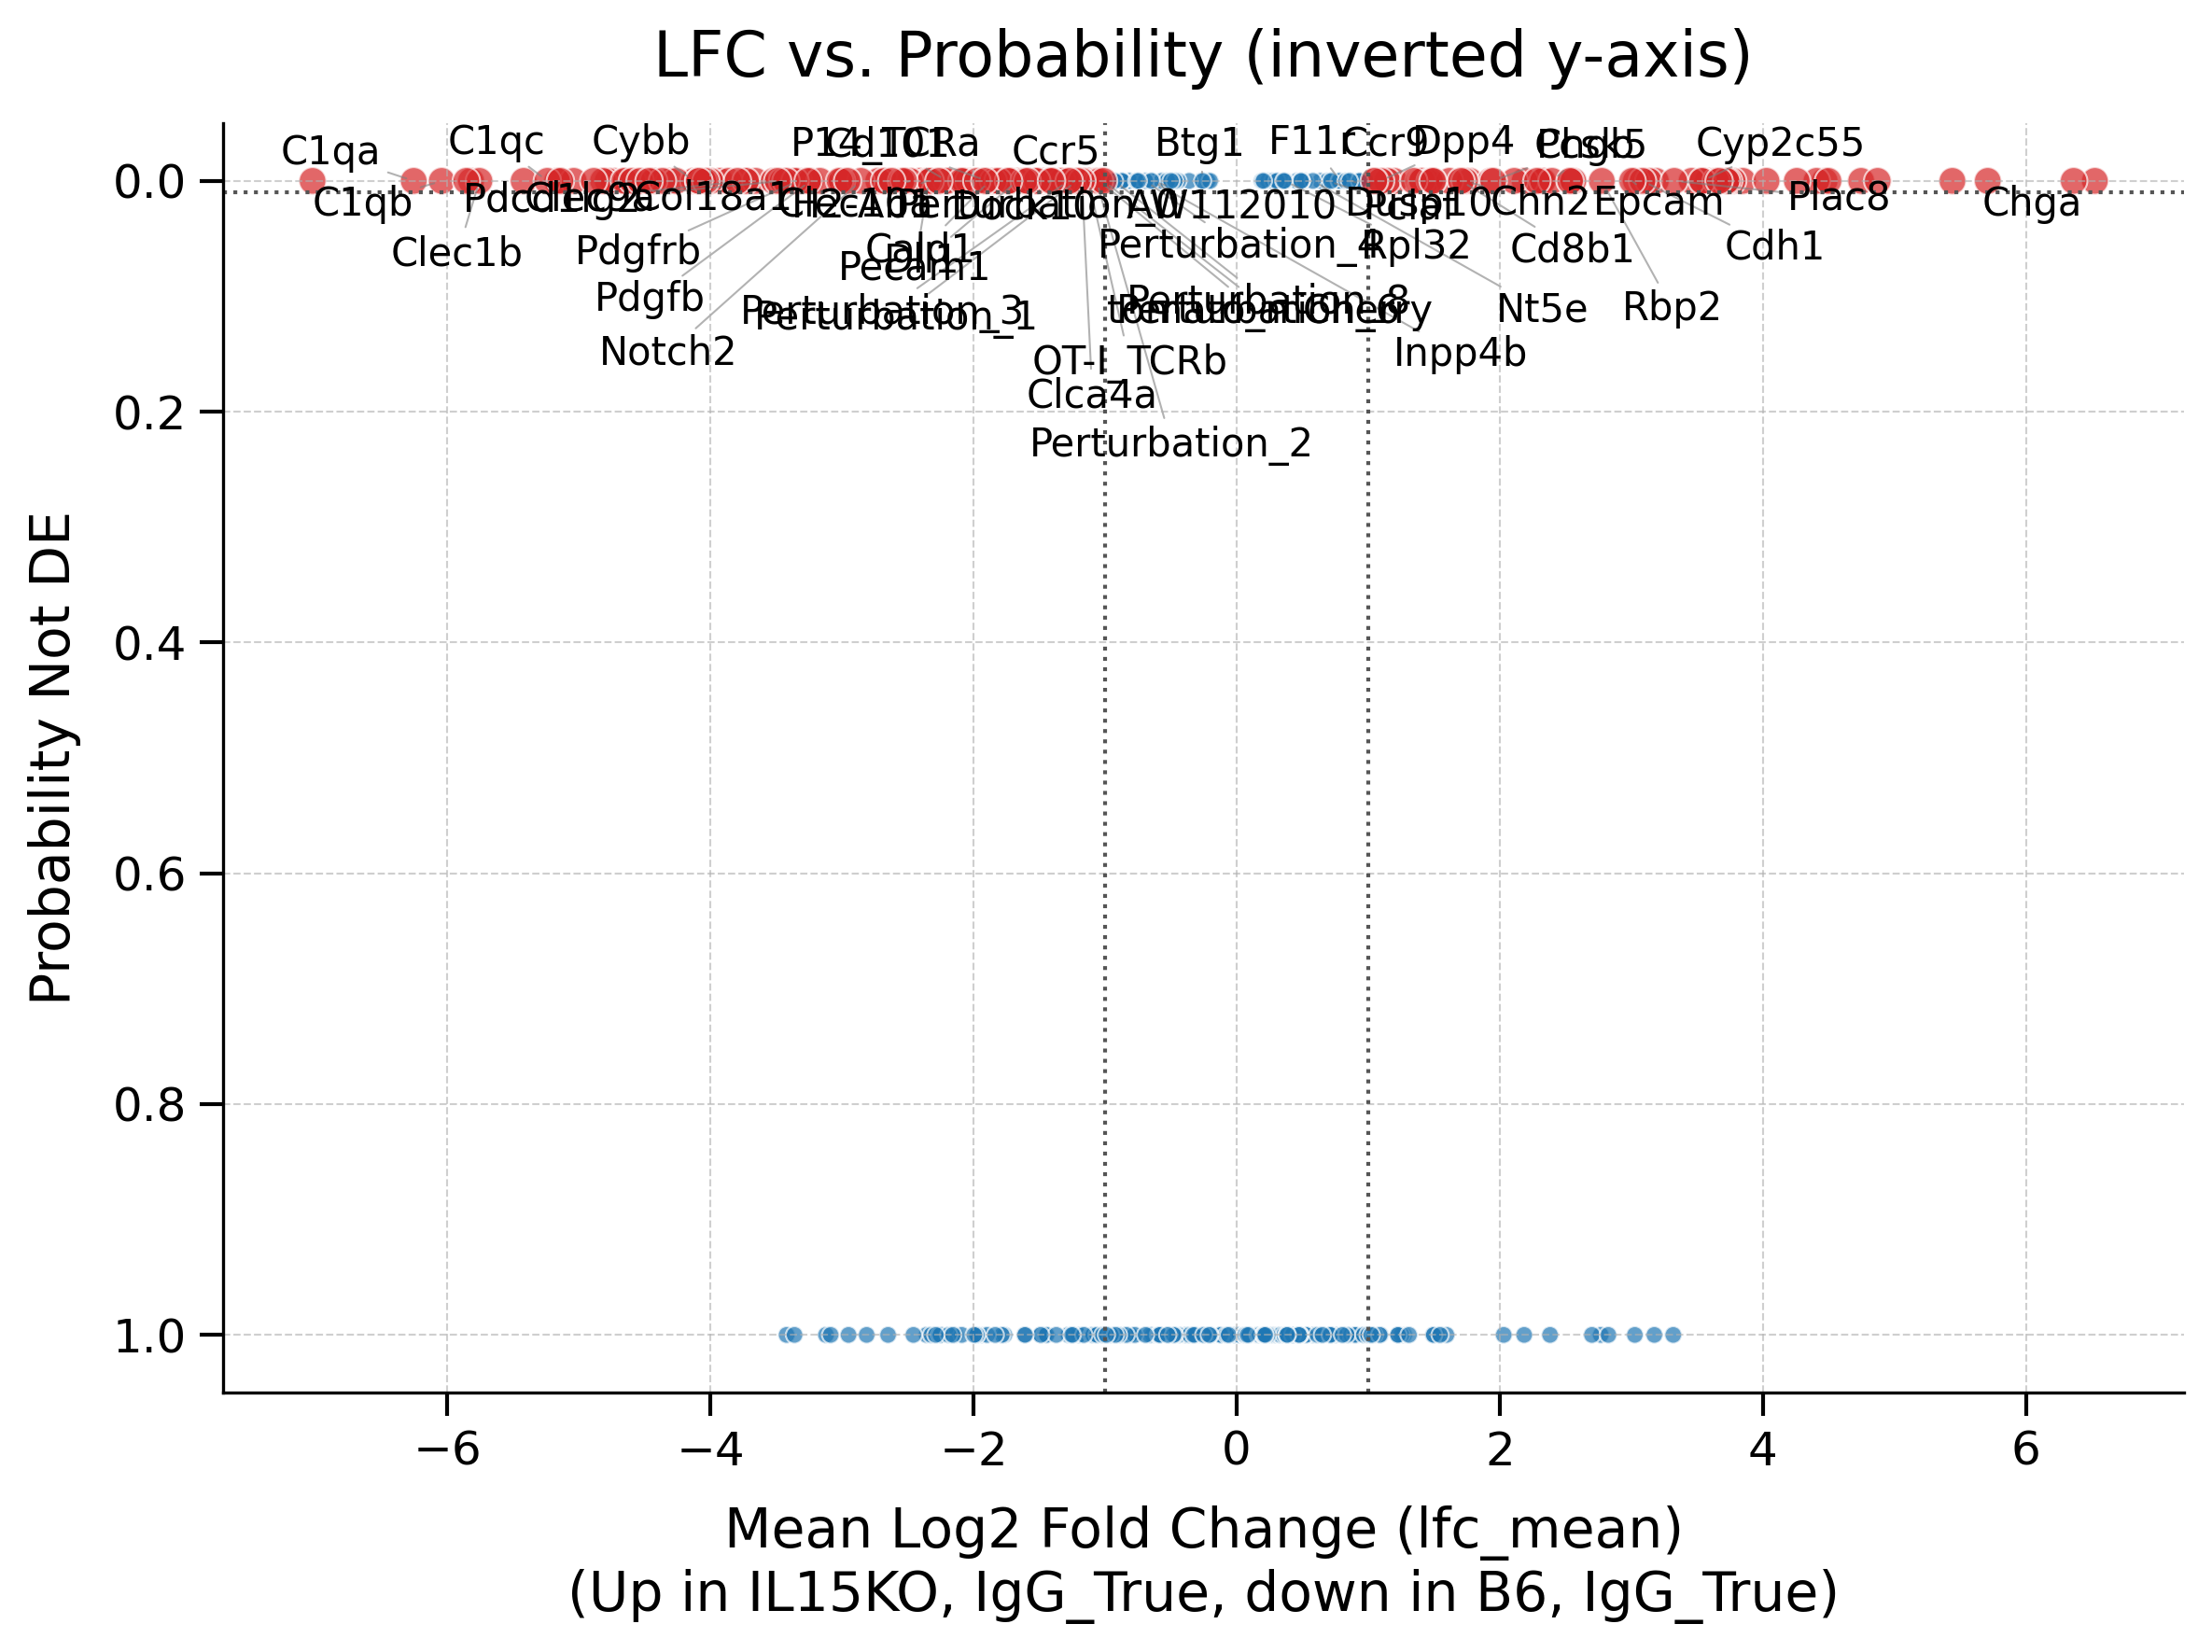

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

lfc = de_result_importance['lfc_mean']
proba = de_result_importance['proba_not_de']

sig_mask = (np.abs(lfc) > 1.0) & (proba < 0.01)
colors   = np.where(sig_mask, '#d62728', '#1f77b4')
sizes    = np.where(sig_mask, 50, 20)

plt.figure(figsize=(8, 6), dpi=300)

plt.scatter(
    lfc,
    proba,
    c=colors,
    s=sizes,
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

plt.xlabel(
    f'Mean Log2 Fold Change (lfc_mean)\n(Up in {batch1}, down in {batch2})',
    fontsize=14,
    labelpad=8
)
plt.ylabel(
    'Probability Not DE',
    fontsize=14,
    labelpad=8
)
plt.title(
    'LFC vs. Probability (inverted y-axis)',
    fontsize=16,
    pad=12
)

plt.gca().invert_yaxis()

plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.6)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.8)
plt.gca().spines['bottom'].set_linewidth(0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().tick_params(direction='out', length=6, width=1)

plt.axhline(y=0.01, color='#555555', linestyle=':', linewidth=1)
plt.axvline(x=1.0,  color='#555555', linestyle=':', linewidth=1)
plt.axvline(x=-1.0, color='#555555', linestyle=':', linewidth=1)

top_n = 50
order = np.argsort(proba.values)[:top_n]
texts = []
for idx in order:
    x_val = lfc.iloc[idx]
    y_val = proba.iloc[idx]
    gene  = de_result_importance.index[idx]
    texts.append(
        plt.text(
            x_val,
            y_val,
            gene,
            fontsize=10,
            ha='center',
            va='center',
            color='black'
        )
    )

adjust_text(
    texts,
    only_move={'points': 'y', 'texts': 'y'},
    arrowprops={'arrowstyle': '-', 'color': 'gray', 'lw': 0.5, 'alpha': 0.6}
)

plt.tight_layout()
plt.show()


In [10]:


# 4. Get uncertainty estimates (multiple samples)
effects_with_uncertainty = supervised_resolvi.get_perturbation_effects(
    n_samples=100,
    return_mean=False  # Returns (n_samples, n_perturbations, n_genes)
)

# Calculate mean and standard deviation
effects_mean = effects_with_uncertainty.mean(axis=0)
effects_std = effects_with_uncertainty.std(axis=0)

# 5. Return as numpy array instead of DataFrame
effects_numpy = supervised_resolvi.get_perturbation_effects(
    return_numpy=True
)


perturbation_1 - Top upregulated genes:
Olfm4      0.160932
S100a4     0.146479
Cd74       0.140134
Il17a      0.136326
Lgr5       0.132411
Jchain     0.131299
Meg3       0.128033
Neurog3    0.125850
Mzb1       0.125348
Scn7a      0.124500
Name: perturbation_1, dtype: float32

perturbation_1 - Top downregulated genes:
Muc13    -0.125823
mt-Co1   -0.117608
Rbp2     -0.101208
Fabp2    -0.093622
Apoa1    -0.074589
Slc9a3   -0.073016
Ifngr1   -0.072394
Il18     -0.068574
Pcsk5    -0.060879
Ifngr2   -0.060798
Name: perturbation_1, dtype: float32

perturbation_2 - Top upregulated genes:
Upp1      0.180055
Cd74      0.155298
H2-Aa     0.086877
Itga6     0.075242
Ccl20     0.074872
Cd8b1     0.061757
Irf8      0.057358
H2-Eb1    0.054356
Il1a      0.053360
Atp1b1    0.047624
Name: perturbation_2, dtype: float32

perturbation_2 - Top downregulated genes:
Tyrobp   -0.097767
Muc13    -0.093395
C1qb     -0.084836
Csf1r    -0.083398
C1qa     -0.076835
Il2rg    -0.075518
Pecam1   -0.072680
Acta2   

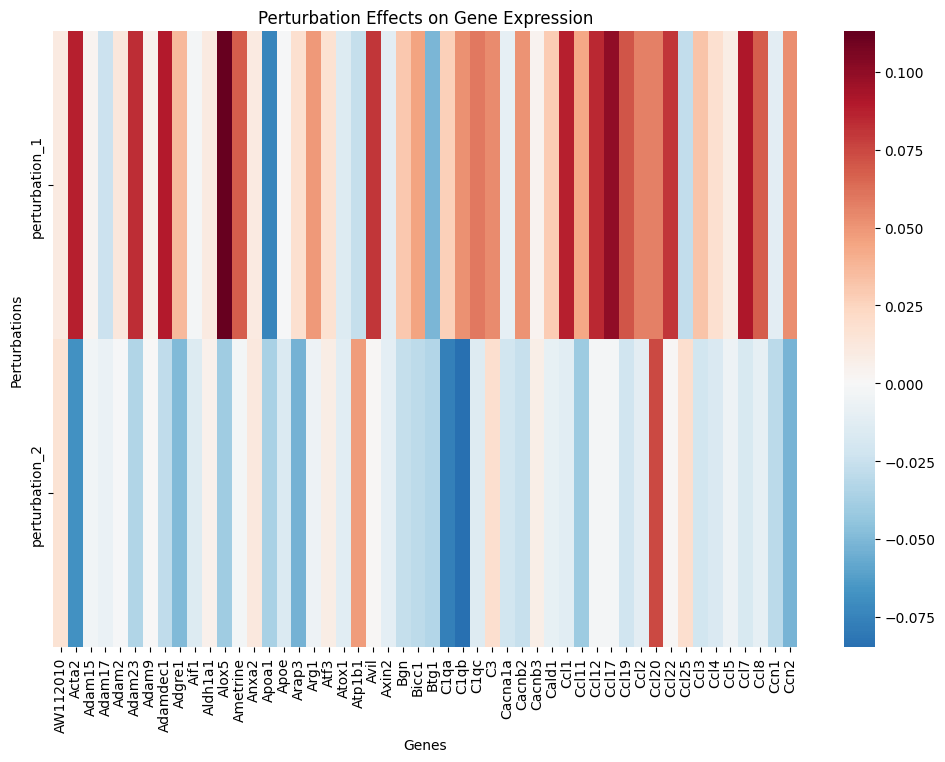

In [9]:
# Extract effects
effects_df = supervised_resolvi.get_perturbation_effects()

# Find genes most affected by each perturbation
for perturbation in effects_df.index:
    # Get top 10 upregulated genes
    top_up = effects_df.loc[perturbation].nlargest(10)
    print(f"\n{perturbation} - Top upregulated genes:")
    print(top_up)
    
    # Get top 10 downregulated genes  
    top_down = effects_df.loc[perturbation].nsmallest(10)
    print(f"\n{perturbation} - Top downregulated genes:")
    print(top_down)

# Visualize effects
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of perturbation effects
plt.figure(figsize=(12, 8))
sns.heatmap(effects_df.iloc[:, :50], cmap='RdBu_r', center=0)  # First 50 genes
plt.title('Perturbation Effects on Gene Expression')
plt.xlabel('Genes')
plt.ylabel('Perturbations')
plt.show()
